# Projet 9 : Développez une preuve de concept

## Contexte

Vous essayez d'obtenir un poste de Data Scientist chez "DataSpace", une entreprise qui accompagne ses clients à concevoir et mettre en œuvre des solutions de data science, tant sur des données structurées que sur des problématiques de traitement d’image ou de texte.

Dans le cadre de votre recrutement, le recruteur aimerait que vous réalisiez une veille et que vous identifiez une méthode plus récente pour améliorer la performance d’un modèle.

J'ai choisi de m’inscrire dans une logique d'amélioration du travail réalisé lors du projet 8 de la formation IA Engineer, dans lequel j’ai implémenté la segmentation sémantique sur le dataset Cityscapes à l’aide d’un modèle U-Net, avec plusieurs variantes.

Ces premières expérimentations ont servi de méthode baseline. Les performances du modèle (mIoU, précision par classe, etc.) sur l’ensemble de validation Cityscapes me fourniront un point de comparaison fiable pour évaluer l’intérêt d’un modèle plus avancé.

Dans ce nouveau projet, je propose de mettre en oeuvre Mask2Former, une architecture récente basée sur des Transformers, dont la robustesse a été démontrée sur Cityscapes et dans des contextes dégradés (benchmark Cityscapes-Adverse, 2024).

L’objectif est de vérifier si ce modèle, plus complexe et mieux adapté aux scènes urbaines variées, apporte un gain significatif en performance et en robustesse.

Le projet prendra la forme d’une preuve de concept (PoC) :
- Je réaliserai une expérimentation contrôlée avec Mask2Former sur un sous-ensemble de Cityscapes,
- Je comparerai les résultats obtenus (visuellement et quantitativement) avec ceux de la baseline U-Net du projet 8, afin de valider l’intérêt du modèle avancé,
- Enfin, je présenterai la comparaison des résultats dans un dashboard Streamlit que je déploierai.

## Contenu des données du jeu de données Cityscapes :

2 dossiers **gtFine** et **leftImg8bit** contenant chacun les images séparés en données de train, val et test. Dans ces trois dossiers, les images sont divisées selon les différentes villes.

- **gtFine/** :

  **_gtFine_color.png* : contient les couleurs des classes de segmentation;
  
  **_gtFine_instanceIds.png* : contient les identifiants d'instance (objets de la même classe mais distincts : chacun a son numero d'instance unique);
  
  **_gtFine_labalIds.png* : contient les identifiants d'étiquette (chaque pixel contient son identifiant de classe);
  
  **_gtFine_polygons.json* : contient les formes des polygones (forme des objets);

- **leftImg8bit/** : les images brutes du jeu de données (photos de rue en RVB).


## Librairies utilisées avec le langage Python :

In [25]:
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 transformers==4.30.2 datasets mlflow pyngrok opencv-python timm

  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached torchvision-0.21.0-cp312-cp312-manylinux1_x86_64.whl.metadata (6.1 kB)
  Using cached torchaudio-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (6.6 kB)
  Using cached transformers-4.30.2-py3-none-any.whl.metadata (113 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  U

In [26]:
!pip install mlflow pyngrok opencv-python timm

In [27]:
!pip uninstall -y sentence-transformers

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os
import sys
sys.path.append('/content/drive/MyDrive/Colab_Notebooks/P9')
os.environ['CUDA_LAUNCH_BLOCKING']="1"
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import gc
from transformers import SegformerConfig, SegformerModel
from transformers import logging
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR
from torchvision import transforms
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score, f1_score, accuracy_score
import shutil
import zipfile
import glob
from PIL import Image
from tqdm import tqdm
from itertools import product
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import subprocess
import mlflow
import mlflow.sklearn
import mlflow.tensorflow
import mlflow.pytorch
import mlflow.keras
from mlflow.tracking import MlflowClient
import threading
from pyngrok import ngrok
from pyngrok import conf
import time
import timm

In [30]:
# Lancement MLFlow
!fuser -k 5000/tcp #tue les processus du port 5000

local_path = "/content/drive/MyDrive/Colab_Notebooks/P9/mlruns"
os.makedirs(local_path,exist_ok=True)
mlflow.set_tracking_uri(f"file:{local_path}")
mlflow.set_experiment("P9")

<Experiment: artifact_location='file:///content/drive/MyDrive/Colab_Notebooks/P9/mlruns/583757542005292477', creation_time=1752227802408, experiment_id='583757542005292477', last_update_time=1752227802408, lifecycle_stage='active', name='P9', tags={}>

## Données image:

### Gestion locale

In [31]:
# Copier le zip en local
zip_path_in = '/content/drive/MyDrive/Colab_Notebooks/P9/Data.zip'
zip_path_out = '/content/Data.zip'
shutil.copy(zip_path_in, zip_path_out)

# Décompresser le zip
temp_path = '/content/temp'
os.makedirs(temp_path, exist_ok=True)
with zipfile.ZipFile(zip_path_out, 'r') as zip_ref:
  zip_ref.extractall(temp_path)

print(f'Fichier dézippé dans {temp_path}')


Fichier dézippé dans /content/temp


### Appariement des images et masques

In [32]:
# Liste d'images et de masques appairés pour le jeu de train
image_paths_train = sorted(glob.glob('/content/temp/Data/leftImg8bit/train/*/*.png',recursive=True))

images_list_train = []
masks_list_train = []

for img_path_train in image_paths_train:
    # Reconstituer le chemin du masque
    filename = os.path.basename(img_path_train)
    city = os.path.basename(os.path.dirname(img_path_train))

    mask_filename = filename.replace('leftImg8bit', 'gtFine_labelIds')

    # Construire le chemin complet vers le masque
    mask_path_train = os.path.join('/content/temp/Data/gtFine/train', city, mask_filename)

    if os.path.exists(mask_path_train):
        images_list_train.append(img_path_train)
        masks_list_train.append(mask_path_train)
    else:
        print(f"ATTENTION: Masque manquant pour {img_path_train}")

print(f"Total images train : {len(images_list_train)}")
print(f"Total masques train : {len(masks_list_train)}")

Total images train : 2975
Total masques train : 2975


In [33]:
# Liste d'images et de masques appairés pour le jeu de validation
image_paths_val = sorted(glob.glob('/content/temp/Data/leftImg8bit/val/*/*.png',recursive=True))

images_list_val = []
masks_list_val = []

for img_path_val in image_paths_val:
    # Reconstituer le chemin du masque
    filename = os.path.basename(img_path_val)
    city = os.path.basename(os.path.dirname(img_path_val))

    mask_filename = filename.replace('leftImg8bit', 'gtFine_labelIds')

    # Construire le chemin complet vers le masque
    mask_path_val = os.path.join('/content/temp/Data/gtFine/val', city, mask_filename)

    if os.path.exists(mask_path_val):
        images_list_val.append(img_path_val)
        masks_list_val.append(mask_path_val)
    else:
        print(f"ATTENTION: Masque manquant pour {img_path_val}")

print(f"Total images val : {len(images_list_val)}")
print(f"Total masques val : {len(masks_list_val)}")

Total images val : 500
Total masques val : 500


## Modèle SegFormer

Papier de référence :

"SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers" Enze Xie et al., NeurIPS 2021, arXiv:2105.15203

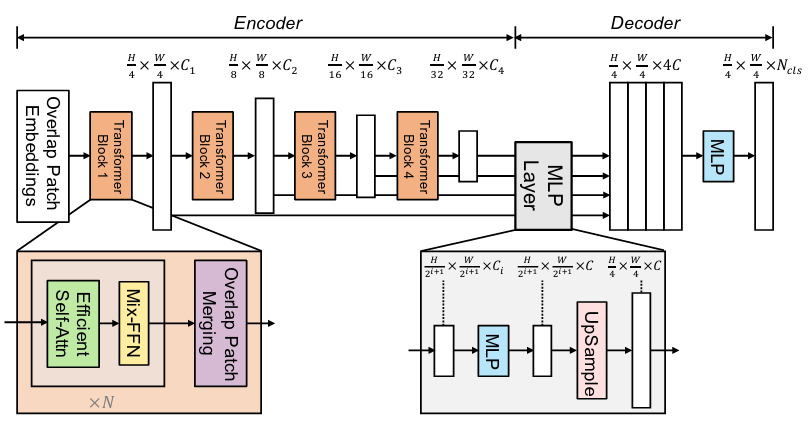


L'architecture de SegFormer repose sur deux modules principaux :

- MiT (Mix Transformer) : un encodeur hiérarchique léger et sans positional encoding.

- All-MLP Decoder : un décodeur sans convolution, uniquement composé de couches MLP.

--------------------------------------------------------------------------------

1. Encodeur – MiT (ou Mix Transformer)

L’encodeur MiT est une architecture hybride conçue pour des tâches de segmentation dense. Il cherche à combiner la capture des relations spatiales des Transformers avec la hiérarchie et l'efficacité computationnelle des CNNs.

La première étape est l'Overlap Patch Embeddings qui utilise une convolution 3x3, avec stride 2 (downsampling léger) et padding 1 (sans perte de bord), pour capturer des informations spatiales locales dès le départ comme dans un CNN. Cela permet de créer des patchs qui se chevauchent (overlapping patches) à la différences des Transformers classiques (ViT) qui utilisent des patchs non chevauchant. Ainsi des informations de voisinage sont conservées, la segmentation des contours est amélioré, sans recourir au positional encoding, ce qui el rend plus flexibles aux résolutions variables.

Après cette étape, l'image est transformée en une séquence de tokens spatiaux avec informations locales. Ces tokens passent ensuite par une série de blocs Transformers appelés MiT (Mix Transformers) blocs.

Chaque bloc MiT est composé des étapes suivantes:

- Efficient self-attention

Cette attention locale se concentre sur des fenêtres locales non chevauchantes au lieu d'avoir une attention globale comme dans les Transformers classique. La self attention est calculée uniquement à l'intérieur de chaque fenêtre (QKV + Softmax) puis on concatène les sorties de chaque fenêtre pour reformer une carte complète. Chaque token intéragit seulement avec ses voisins proches afin de capturer les relations proches sans exploser la mémoire GPU. La capture des relations plus longues distances est compensée par le multi-échelle.

- Mix-FFN (Feed-Forward Network)

C'est un FFN amélioré qui intègre une convolution 3x3 entre les couches linéaires pour ajouter de l'information spatiale : Linear -> ReLU -> Conv 3x3 -> Linear. Contrairement au FFN standard qui agit indépendamment sur chaque token, le Mix-FFN permet de mieux distinguer les bords et formes locales de l'image.

- Overlap Patch Merging

A la fin de chaque bloc Transformers, l'Overlap Patch Merging est réalisé. C'est une convolution avec chevauchement (stride < taille convolution) qui permet de faire un downsampling progressif de la carte des caractéristiques tout en conservant des informations locales : le nombre de canaux est doublé et la taille spatiale est divisée par deux.

2. Décodeur – MLP-based Lightweight Decoder

Le décodeur est simple mais puissant. Il repose sur des MLPs uniquement, sans opérations convolutionnelles.

SegFormer reçoit depuis l’encodeur MiT 4 niveaux de cartes de caractéristiques correspondant aux résolutions suivantes :

- Stage 1 : 1/4 de la taille d’origine

- Stage 2 : 1/8

- Stage 3 : 1/16

- Stage 4 : 1/32

Chaque niveau a une profondeur différente (i.e. nombre de canaux : 64, 128, 320, 512).

Chaque carte de caractéristiques est projetée avec une couche linéaire (équivalent à une Conv2d 1×1) pour uniformiser leur nombre de canaux. Ainsi, tous les niveaux sont projetés dans un espace commun de dimension C (souvent 256).

Puis elles sont upsamplées à la même taille spatiale (souvent H/4,W/4, c’est-à-dire la résolution du premier niveau).

Les 4 cartes de caractéristiques ayant maintenant la même résolution spatiale et le même nombre de canaux sont ensuite sommées ou concaténées, selon l’implémentation.

Une dernière Conv2d 1×1 prédit la segmentation par pixel sur les classes cibles.

Enfin, on effectue un upsampling final à la taille de l’image d’origine.


### Entrainement from scratch de SegFormer sans Data Augmentation

In [38]:
class SegFormer(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        # Configuration du modèle B1 from scratch
        config = SegformerConfig(
            num_labels=num_classes,
            depths=[2, 2, 2, 2],
            hidden_sizes=[64, 128, 320, 512],
            decoder_hidden_size=256,
            output_attentions=True,
            output_hidden_states=True
        )
        self.backbone = SegformerModel(config)

        # Tête de décodage personnalisée
        self.decode_head = nn.Sequential(
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, num_classes, kernel_size=1)
        )

    def forward(self, x, output_attentions=False, output_hidden_states=False):
        outputs = self.backbone(pixel_values=x, output_attentions=output_attentions, output_hidden_states=output_hidden_states)
        feats = outputs.last_hidden_state  # [B, 256, H/4, W/4]
        out = self.decode_head(feats)
        out = F.interpolate(out, size=x.shape[2:], mode="bilinear", align_corners=False)
        return out, outputs.attentions, outputs.hidden_states


In [14]:
class MyCityscapesDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.img_transform = transforms.Compose([
        transforms.Resize((512, 1024)),  # si tu réduis la résolution
        transforms.ToTensor(),           # convertit en float32, [0, 1]
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # => [-1, 1]
        ])
        self.mask_transform = transforms.Resize((512, 1024), interpolation=Image.NEAREST)

    def map_to_8classes(self, mask):
        id_to_supercat = {
                0: 'vide', 1: 'vide', 2: 'vide', 3: 'vide', 4: 'vide', 5: 'vide', 6: 'vide',
                7: 'route/trottoir', 8: 'route/trottoir', 9: 'route/trottoir',10: 'route/trottoir',
                11: 'construction', 12: 'construction', 13: 'construction',14: 'construction',
                15: 'construction', 16: 'construction', 17: 'objet', 18: 'objet',19: 'objet',
                20: 'objet', 21: 'nature', 22: 'nature', 23: 'ciel', 24: 'humain',25: 'humain',
                26: 'vehicule', 27: 'vehicule', 28: 'vehicule',29: 'vehicule', 30: 'vehicule',
                31: 'vehicule', 32: 'vehicule', 33: 'vehicule'
                }

        supercat_to_id = {
                'vide': 0, 'route/trottoir': 1, 'construction': 2, 'objet': 3,
                'nature': 4, 'ciel': 5, 'humain': 6, 'vehicule': 7
                }

        # Appliquer le mapping à chaque pixel
        mapped_mask = np.vectorize(lambda x: supercat_to_id[id_to_supercat.get(x, 'vide')])(mask)
        return mapped_mask

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])
        mask = self.map_to_8classes(np.array(mask))

        if self.transform:
            img = self.img_transform(img)
            mask = self.mask_transform(Image.fromarray(mask.astype(np.uint8)))
            mask = torch.from_numpy(np.array(mask)).long()
        else:
            img = transforms.ToTensor()(img)
            img = transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)(img)

        mask = mask.long()
        return img, mask

    def __len__(self):
        return len(self.image_paths)

In [35]:
# === FONCTIONS UTILITAIRES ===

def get_distinct_palette(num_classes=8):
    cmap = plt.get_cmap('tab20', num_classes - 1)
    palette = np.zeros((num_classes, 3), dtype=np.uint8)
    for i in range(1, num_classes):
        r, g, b = cmap(i - 1)[:3]
        palette[i] = [int(r * 255), int(g * 255), int(b * 255)]
    return palette

PALETTE = get_distinct_palette()

def decode_mask(mask, palette=PALETTE):
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id in range(len(palette)):
        color_mask[mask == cls_id] = palette[cls_id]
    color_mask[mask == 255] = [0, 0, 0]  # Ignorés en noir
    return Image.fromarray(color_mask)

def create_overlay(image_pil, mask_pil, alpha=0.5):
    image_np = np.array(image_pil.convert("RGB")).astype(np.uint8)
    mask_np = np.array(mask_pil.convert("RGB")).astype(np.uint8)
    overlay_np = (alpha * image_np + (1 - alpha) * mask_np).astype(np.uint8)
    return Image.fromarray(overlay_np)

def compute_confusion_metrics(conf_matrix):
    TP = np.diag(conf_matrix)
    FP = conf_matrix.sum(axis=0) - TP
    FN = conf_matrix.sum(axis=1) - TP
    support = conf_matrix.sum(axis=1)

    denom = TP + FP + FN
    iou_per_class = np.divide(TP, denom, out=np.zeros_like(TP, dtype=float), where=denom != 0)
    mean_iou = np.mean(iou_per_class)
    weighted_iou = np.sum(iou_per_class * support) / support.sum()

    precision = np.divide(TP, TP + FP, out=np.zeros_like(TP, dtype=float), where=(TP + FP) != 0)
    recall = np.divide(TP, TP + FN, out=np.zeros_like(TP, dtype=float), where=(TP + FN) != 0)
    dice_per_class = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(TP, dtype=float), where=(precision + recall) != 0)

    dice_macro = dice_per_class.mean()
    dice_weighted = np.sum(dice_per_class * support) / support.sum()
    dice_global = 2 * TP.sum() / (2 * TP.sum() + FP.sum() + FN.sum())

    accuracy = TP.sum() / support.sum()

    return {
        "iou_per_class": iou_per_class,
        "mean_iou": mean_iou,
        "weighted_iou": weighted_iou,
        "dice_per_class": dice_per_class,
        "dice_macro": dice_macro,
        "dice_weighted": dice_weighted,
        "dice_global": dice_global,
        "accuracy": accuracy
    }


🔷 Début de l'entrainement de SegFormer_augmentationFalse_lr1e-05_wd0.01_batch_size2



[Final Evaluation]: 100%|██████████| 250/250 [04:39<00:00,  1.12s/it]


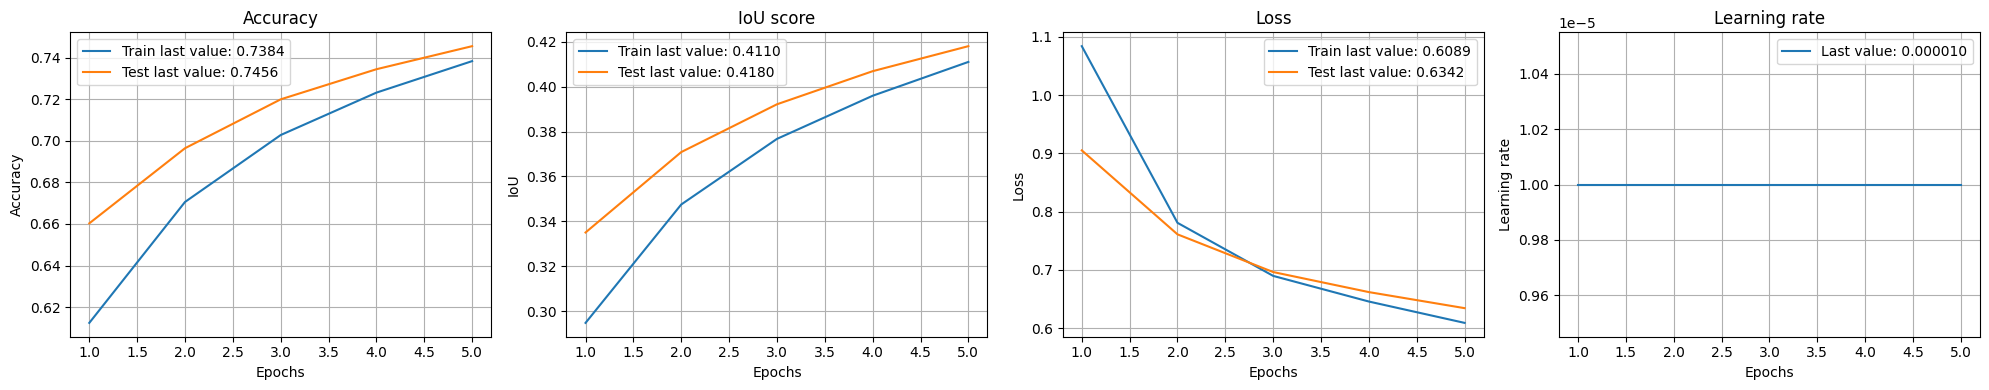


🔷 Début de l'entrainement de SegFormer_augmentationFalse_lr1e-05_wd0.01_batch_size4



[Final Evaluation]: 100%|██████████| 125/125 [04:34<00:00,  2.19s/it]


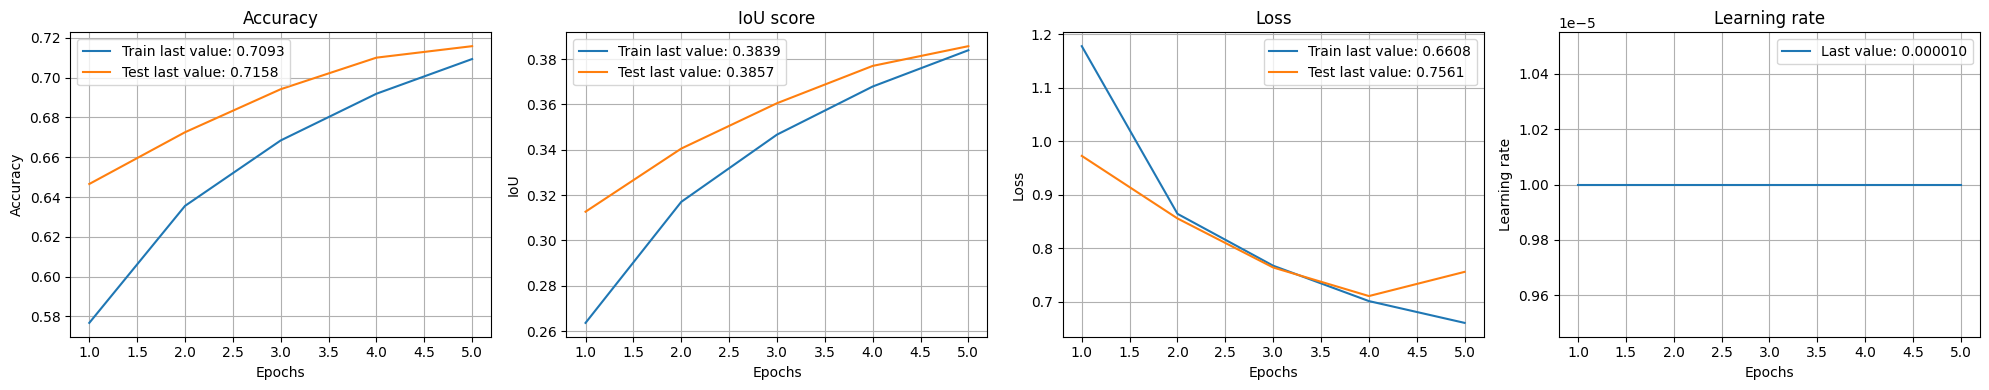


🔷 Début de l'entrainement de SegFormer_augmentationFalse_lr1e-05_wd0.01_batch_size8



[Train Epoch 1]:  88%|████████▊ | 326/372 [33:40<06:36,  8.61s/it]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8

# === Hyperparamètres ===
# learning_rate_list = [5e-4, 1e-4, 1e-5]
learning_rate = 1e-5
batch_size_list = [2,4,8]
num_epochs = 5
weight_decay_list = [0.01,0.05]
patience = 3
lr_patience = 3
min_lr = 1e-6

# === Dataset / DataLoader ===
train_dataset = MyCityscapesDataset(images_list_train, masks_list_train, transform=True)
val_dataset   = MyCityscapesDataset(images_list_val, masks_list_val, transform=True)

for weight_decay, batch_size in product(weight_decay_list, batch_size_list):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = SegFormer(num_classes=num_classes).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=lr_patience, min_lr=min_lr, verbose=True)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

    run_name = f"SegFormer_augmentationFalse_lr{learning_rate}_wd{weight_decay}_batch_size{batch_size}"

    with mlflow.start_run(run_name=run_name):
        print(f"\n🔷 Début de l'entrainement de {run_name}\n")
        mlflow.log_params({
            "lr": learning_rate,
            "batch_size": batch_size,
            "epochs": num_epochs,
            "model": "SegFormer",
            "weight_decay": weight_decay,
            "augmentation": "False"
        })

        best_val_iou = 0.0
        early_stop_counter = 0
        train_losses,val_losses,train_ious,val_ious,train_accs,val_accs,lr_list = [],[],[],[],[],[],[]
        train_cm = np.zeros((num_classes, num_classes), dtype=np.int64)
        val_cm = np.zeros((num_classes, num_classes), dtype=np.int64)

        for epoch in range(1, num_epochs + 1):
            model.train()
            running_loss = 0.0
            train_metrics = {'TP': np.zeros(num_classes), 'FP': np.zeros(num_classes), 'FN': np.zeros(num_classes), 'support': np.zeros(num_classes)}

            for imgs, masks in tqdm(train_loader, desc=f"[Train Epoch {epoch}]"):
                imgs, masks = imgs.to(device), masks.to(device)

                optimizer.zero_grad()
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * imgs.size(0)

                preds = torch.argmax(outputs, dim=1).detach().cpu().numpy().flatten()
                targets = masks.detach().cpu().numpy().flatten()
                batch_cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))
                train_cm += batch_cm

                del imgs, masks, outputs, loss, preds, targets
                torch.cuda.empty_cache()
                gc.collect()

            avg_train_loss = running_loss / len(train_loader.dataset)
            lr_list.append(optimizer.param_groups[0]['lr'])


            # === Validation ===
            model.eval()
            val_running_loss = 0

            with torch.no_grad():
                for imgs, masks in tqdm(val_loader, desc=f"[Val Epoch {epoch}]"):
                    imgs, masks = imgs.to(device), masks.to(device)
                    outputs = model(imgs)
                    loss = criterion(outputs, masks)
                    val_running_loss += loss.item() * imgs.size(0)

                    preds = torch.argmax(outputs, dim=1).cpu().numpy().flatten()
                    targets = masks.cpu().numpy().flatten()

                    batch_cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))
                    val_cm += batch_cm

                    del imgs, masks, outputs, loss, preds, targets
                    torch.cuda.empty_cache()
                    gc.collect()

            avg_val_loss = val_running_loss / len(val_loader.dataset)
            train_results = compute_confusion_metrics(train_cm)
            val_results = compute_confusion_metrics(val_cm)

            if val_results["mean_iou"] > best_val_iou:
                best_val_iou = val_results["mean_iou"]
                early_stop_counter = 0
                best_model_path = f"/content/drive/MyDrive/Colab_Notebooks/P9/save/{run_name}.pt"
                torch.save(model.state_dict(), best_model_path)
                mlflow.log_artifact(best_model_path)

                # Sauvegarde des métriques du meilleur modèle
                best_train_loss = avg_train_loss
                best_train_iou = train_results["mean_iou"]
                best_train_accuracy = train_results["accuracy"]
                best_val_loss = avg_val_loss
                best_val_accuracy = val_results["accuracy"]
            else:
                early_stop_counter += 1
                if early_stop_counter >= patience:
                    print(f"Early stopping triggered at epoch {epoch}")
                    break

            scheduler.step(val_results["mean_iou"])

            # Courbes d'apprentissage
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            train_accs.append(train_results["accuracy"])
            val_accs.append(val_results["accuracy"])
            train_ious.append(train_results["mean_iou"])
            val_ious.append(val_results["mean_iou"])

        # Reprise des meilleurs poids
        model.load_state_dict(torch.load(best_model_path))
        model.eval()

        # === Évaluation finale ===
        final_val_cm = np.zeros((num_classes, num_classes), dtype=np.int64)

        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc="[Final Evaluation]"):
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                preds = torch.argmax(outputs, dim=1).cpu().numpy().flatten()
                targets = masks.cpu().numpy().flatten()
                batch_cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))
                final_val_cm += batch_cm

        # === Calcul des métriques finales ===
        final_results = compute_confusion_metrics(final_val_cm)

        # === Log MLflow : uniquement les métriques du meilleur modèle ===
        mlflow.log_metric("train_loss", best_train_loss)
        mlflow.log_metric("train_iou", best_train_iou)
        mlflow.log_metric("train_accuracy", best_train_accuracy)
        mlflow.log_metric("val_loss", best_val_loss)
        mlflow.log_metric("val_accuracy", best_val_accuracy)
        mlflow.log_metric("mean_iou_macro", final_results["mean_iou"])
        mlflow.log_metric("mean_iou_weighted", final_results["weighted_iou"])
        mlflow.log_metric("dice_macro", final_results["dice_macro"])
        mlflow.log_metric("dice_weighted", final_results["dice_weighted"])
        mlflow.log_metric("dice_global", final_results["dice_global"])

        for i in range(num_classes):
            mlflow.log_metric(f"iou_class_{i}", final_results["iou_per_class"][i])
            mlflow.log_metric(f"dice_class_{i}", final_results["dice_per_class"][i])

        # === Matrice de confusion ===
        plt.figure(figsize=(8, 6))
        sns.heatmap(final_val_cm, annot=True, fmt="d", cmap="Blues")
        plt.xlabel("Prédictions")
        plt.ylabel("Réels")
        plt.title("Matrice de confusion")
        final_conf_path = f"/content/drive/MyDrive/Colab_Notebooks/P9/save/conf_matrix_{run_name}.png"
        plt.savefig(final_conf_path)
        mlflow.log_artifact(final_conf_path)
        plt.close()

        # === LOG COURBES ===
        epochs_range = list(range(1, len(train_losses) + 1))
        fig, axs = plt.subplots(1, 4, figsize=(20, 4))

        # --- Accuracy
        axs[0].plot(epochs_range, train_accs, label=f"Train last value: {train_accs[-1]:.4f}")
        axs[0].plot(epochs_range, val_accs, label=f"Test last value: {val_accs[-1]:.4f}")
        axs[0].set_title("Accuracy")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()
        axs[0].grid(True)

        # --- IoU
        axs[1].plot(epochs_range, train_ious, label=f"Train last value: {train_ious[-1]:.4f}")
        axs[1].plot(epochs_range, val_ious, label=f"Test last value: {val_ious[-1]:.4f}")
        axs[1].set_title("IoU score")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("IoU")
        axs[1].legend()
        axs[1].grid(True)

        # --- Loss
        axs[2].plot(epochs_range, train_losses, label=f"Train last value: {train_losses[-1]:.4f}")
        axs[2].plot(epochs_range, val_losses, label=f"Test last value: {val_losses[-1]:.4f}")
        axs[2].set_title("Loss")
        axs[2].set_xlabel("Epochs")
        axs[2].set_ylabel("Loss")
        axs[2].legend()
        axs[2].grid(True)

        # --- Learning rate
        if len(lr_list) > len(epochs_range):
            axs[3].plot(epochs_range, lr_list[:-1], label=f"Last value: {lr_list[-1]:.6f}")
        else :
            axs[3].plot(epochs_range, lr_list, label=f"Last value: {lr_list[-1]:.6f}")
        axs[3].set_title("Learning rate")
        axs[3].set_xlabel("Epochs")
        axs[3].set_ylabel("Learning rate")
        axs[3].legend()
        axs[3].grid(True)

        plt.tight_layout()
        curve_path = f"/content/drive/MyDrive/Colab_Notebooks/P9/save/courbe_entrainement_{run_name}.png"
        plt.savefig(curve_path)
        mlflow.log_artifact(curve_path)
        plt.show()
        plt.close()

        mlflow.end_run()


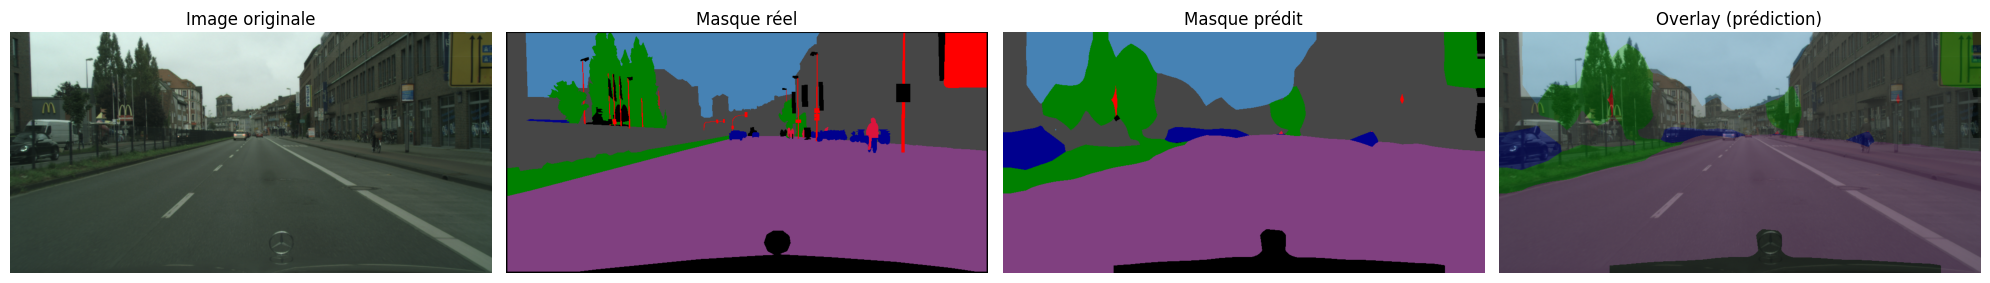

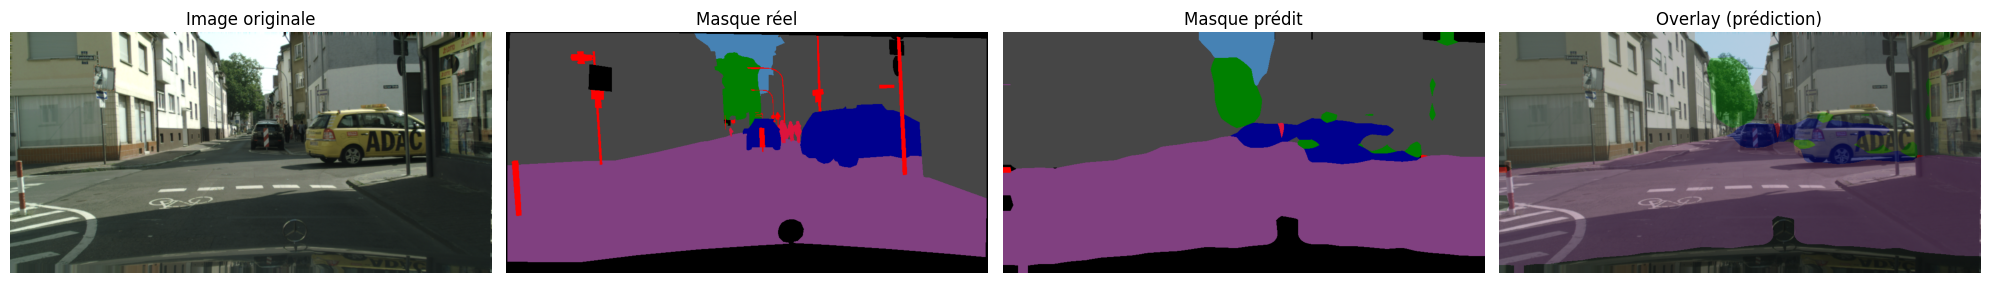

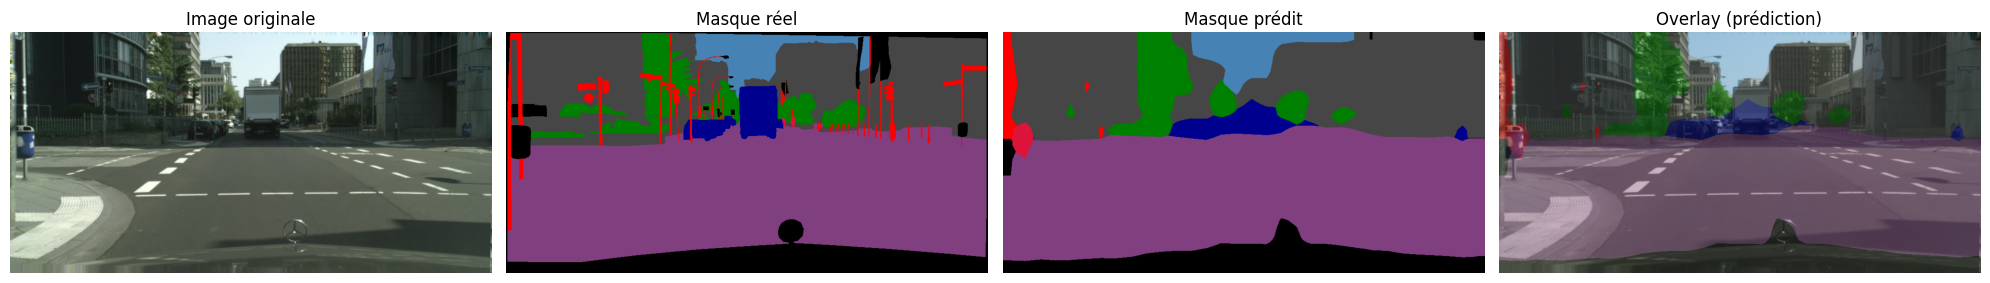

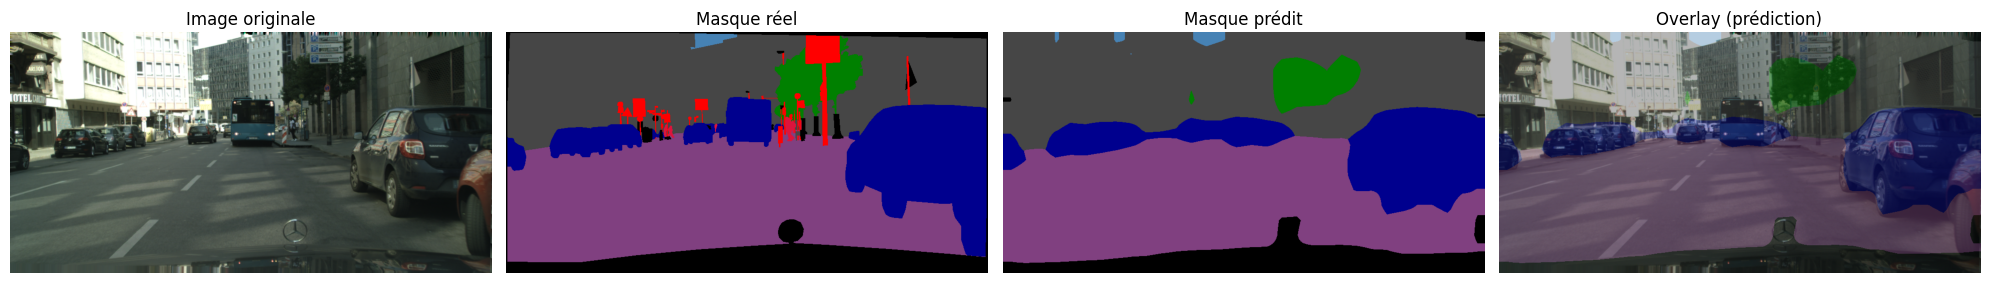

In [ ]:
def decode_segmentation_mask(mask_2d):
    """
    Convertit un masque 2D (avec classes 0..7) en image RGB colorée pour visualisation.
    """
    colors = {
        0: (0, 0, 0),         # void - noir
        1: (128, 64, 128),    # flat - violet
        2: (70, 70, 70),      # construction - gris
        3: (255, 0, 0),       # object - rouge
        4: (0, 128, 0),       # nature - vert
        5: (70, 130, 180),    # sky - bleu ciel
        6: (220, 20, 60),     # human - rose
        7: (0, 0, 142),       # vehicle - bleu foncé
    }

    h, w = mask_2d.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in colors.items():
        rgb_mask[mask_2d == class_id] = color
    return rgb_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "/content/drive/MyDrive/Colab_Notebooks/P9/save/SegFormer_augmentationFalse_lr0.0001_wd0.01_batch_size2.pt"
model = SegFormer(num_classes=8)
# Charger les poids entraînés
model.load_state_dict(torch.load(best_model_path, map_location="cpu"))
model.to(device)
model.eval()

# Charger les images dans un dataset avec les mêmes prétraitements
dataset = MyCityscapesDataset(
    image_paths = ["/content/temp/Data/leftImg8bit/val/munster/munster_000004_000019_leftImg8bit.png",
                  "/content/temp/Data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png",
                  "/content/temp/Data/leftImg8bit/val/frankfurt/frankfurt_000000_011007_leftImg8bit.png",
                  "/content/temp/Data/leftImg8bit/val/frankfurt/frankfurt_000000_013382_leftImg8bit.png"],
    mask_paths = ["/content/temp/Data/gtFine/val/munster/munster_000004_000019_gtFine_labelIds.png",
                 "/content/temp/Data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png",
                 "/content/temp/Data/gtFine/val/frankfurt/frankfurt_000000_011007_gtFine_labelIds.png",
                 "/content/temp/Data/gtFine/val/frankfurt/frankfurt_000000_013382_gtFine_labelIds.png"],
    transform = True
    )
for i in range(4):
    img_tensor, mask_tensor = dataset[i]  # Tenseur image + masque (après preprocessing)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = ((img_np * 0.5) + 0.5) * 255
    img_np = np.clip(img_np, 0, 255).astype(np.uint8)
    true_mask = mask_tensor.numpy()

    # Prédiction
    with torch.no_grad():
        inputs = img_tensor.unsqueeze(0).to(device)
        outputs = model(inputs)
        pred_mask = torch.argmax(outputs, dim=1).squeeze(0).cpu().numpy()

    # Masques colorés
    pred_rgb = decode_segmentation_mask(pred_mask)
    true_rgb = decode_segmentation_mask(true_mask)

    # Superpositions
    overlay_pred = cv2.addWeighted(img_np, 0.6, pred_rgb, 0.4, 0)
    overlay_true = cv2.addWeighted(img_np, 0.6, true_rgb, 0.4, 0)

    # Affichage
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img_np)
    axes[0].set_title("Image originale")

    axes[1].imshow(true_rgb)
    axes[1].set_title("Masque réel")

    axes[2].imshow(pred_rgb)
    axes[2].set_title("Masque prédit")

    axes[3].imshow(overlay_pred)
    axes[3].set_title("Overlay (prédiction)")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

### Entrainement from scratch de SegFormer avec Data Augmentation



In [12]:
class MyCityscapesDataset(Dataset):
    def __init__(self, image_paths, mask_paths, use_augmentations=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.use_augmentations = use_augmentations

        # Transformations classiques (torchvision)
        self.img_transform = transforms.Compose([
            transforms.Resize((512, 1024)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        self.mask_transform = transforms.Resize((512, 1024), interpolation=Image.NEAREST)

        # Pipeline d'augmentations (Albumentations)
        self.augment = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.0, rotate_limit=1, p=0.5),
            A.Resize(512, 1024),
            ToTensorV2()
        ])

    def map_to_8classes(self, mask):
        id_to_supercat = {
            0: 'vide', 1: 'vide', 2: 'vide', 3: 'vide', 4: 'vide', 5: 'vide', 6: 'vide',
            7: 'route/trottoir', 8: 'route/trottoir', 9: 'route/trottoir', 10: 'route/trottoir',
            11: 'construction', 12: 'construction', 13: 'construction', 14: 'construction',
            15: 'construction', 16: 'construction', 17: 'objet', 18: 'objet', 19: 'objet',
            20: 'objet', 21: 'nature', 22: 'nature', 23: 'ciel', 24: 'humain', 25: 'humain',
            26: 'vehicule', 27: 'vehicule', 28: 'vehicule', 29: 'vehicule', 30: 'vehicule',
            31: 'vehicule', 32: 'vehicule', 33: 'vehicule'
        }

        supercat_to_id = {
            'vide': 0, 'route/trottoir': 1, 'construction': 2, 'objet': 3,
            'nature': 4, 'ciel': 5, 'humain': 6, 'vehicule': 7
        }

        mapped_mask = np.vectorize(lambda x: supercat_to_id[id_to_supercat.get(x, 'vide')])(mask)
        return mapped_mask

    def __getitem__(self, idx):
        # Charger image + masque
        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])
        mask = self.map_to_8classes(np.array(mask))

        img_orig = self.img_transform(img)
        mask_orig = self.mask_transform(Image.fromarray(mask.astype(np.uint8)))
        mask_orig = torch.from_numpy(np.array(mask_orig)).long()

        if self.use_augmentations:
            augmented = self.augment(image=np.array(img), mask=mask.astype(np.uint8))
            img_aug = augmented["image"]       # Tensor normalisé
            mask_aug = augmented["mask"].long()
            return torch.stack([img_orig, img_aug]), torch.stack([mask_orig, mask_aug])
        else:
            return img_orig, mask_orig

    def __len__(self):
        return len(self.image_paths)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



🔷 Début de l'entrainement de SegFormer_epoch50_augmentationTrue_lr0.0005_wd0.01_batch_size8



[Final Evaluation]: 100%|██████████| 63/63 [01:53<00:00,  1.81s/it]


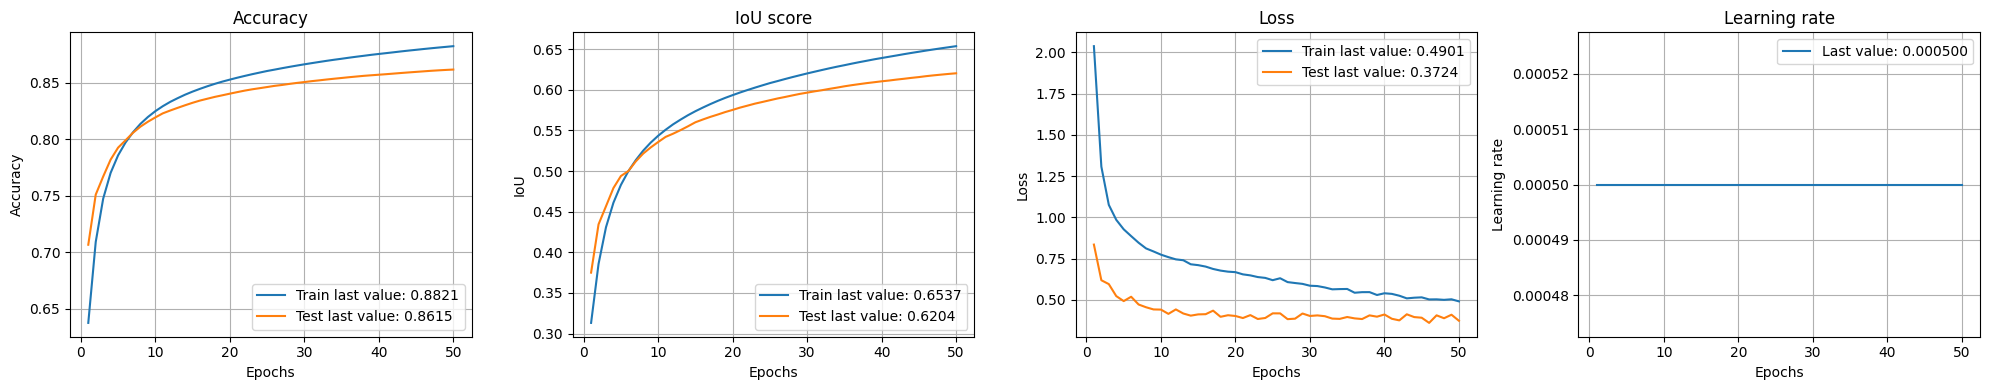

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8

# === Hyperparamètres ===
# learning_rate_list = [5e-4, 1e-4]
learning_rate = 5e-4
# batch_size_list = [2,4,8]
batch_size = 8
num_epochs = 50
# weight_decay_list = [0.01,0.05]
weight_decay = 0.01
patience = 3
lr_patience = 3
min_lr = 1e-6

# === Dataset / DataLoader ===
train_dataset = MyCityscapesDataset(images_list_train, masks_list_train, use_augmentations=True)
val_dataset   = MyCityscapesDataset(images_list_val, masks_list_val, use_augmentations=False)

# for learning_rate in  learning_rate_list:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

model = SegFormer(num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=lr_patience, min_lr=min_lr, verbose=True)
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

run_name = f"SegFormer_epoch50_augmentationTrue_lr{learning_rate}_wd{weight_decay}_batch_size{batch_size}"

with mlflow.start_run(run_name=run_name):
    print(f"\n🔷 Début de l'entrainement de {run_name}\n")
    mlflow.log_params({
        "lr": learning_rate,
        "batch_size": batch_size,
        "epochs": num_epochs,
        "model": "SegFormer",
        "weight_decay": weight_decay,
        "augmentation": "False"
    })

    best_val_iou = 0.0
    early_stop_counter = 0
    train_losses,val_losses,train_ious,val_ious,train_accs,val_accs,lr_list = [],[],[],[],[],[],[]
    train_cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    val_cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        train_metrics = {'TP': np.zeros(num_classes), 'FP': np.zeros(num_classes), 'FN': np.zeros(num_classes), 'support': np.zeros(num_classes)}

        for imgs, masks in tqdm(train_loader, desc=f"[Train Epoch {epoch}]"):
            if imgs.dim() == 5:  # (B, 2, C, H, W)
                B, K, C, H, W = imgs.shape
                imgs = imgs.view(B*K, C, H, W)
                masks = masks.view(B*K, H, W)
            imgs, masks = imgs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

            preds = torch.argmax(outputs, dim=1).detach().cpu().numpy().flatten()
            targets = masks.detach().cpu().numpy().flatten()
            batch_cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))
            train_cm += batch_cm

            del imgs, masks, outputs, loss, preds, targets
            torch.cuda.empty_cache()
            gc.collect()

        avg_train_loss = running_loss / len(train_loader.dataset)
        lr_list.append(optimizer.param_groups[0]['lr'])


        # === Validation ===
        model.eval()
        val_running_loss = 0

        with torch.no_grad():
            for imgs, masks in tqdm(val_loader, desc=f"[Val Epoch {epoch}]"):
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, masks)
                val_running_loss += loss.item() * imgs.size(0)

                preds = torch.argmax(outputs, dim=1).cpu().numpy().flatten()
                targets = masks.cpu().numpy().flatten()

                batch_cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))
                val_cm += batch_cm

                del imgs, masks, outputs, loss, preds, targets
                torch.cuda.empty_cache()
                gc.collect()

        avg_val_loss = val_running_loss / len(val_loader.dataset)
        train_results = compute_confusion_metrics(train_cm)
        val_results = compute_confusion_metrics(val_cm)

        if val_results["mean_iou"] > best_val_iou:
            best_val_iou = val_results["mean_iou"]
            early_stop_counter = 0
            best_model_path = f"/content/drive/MyDrive/Colab_Notebooks/P9/save/{run_name}.pt"
            torch.save(model.state_dict(), best_model_path)
            mlflow.log_artifact(best_model_path)

            # Sauvegarde des métriques du meilleur modèle
            best_train_loss = avg_train_loss
            best_train_iou = train_results["mean_iou"]
            best_train_accuracy = train_results["accuracy"]
            best_val_loss = avg_val_loss
            best_val_accuracy = val_results["accuracy"]
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch}")
                break

        scheduler.step(val_results["mean_iou"])

        # Courbes d'apprentissage
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(train_results["accuracy"])
        val_accs.append(val_results["accuracy"])
        train_ious.append(train_results["mean_iou"])
        val_ious.append(val_results["mean_iou"])

    # Reprise des meilleurs poids
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    # === Évaluation finale ===
    final_val_cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="[Final Evaluation]"):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy().flatten()
            targets = masks.cpu().numpy().flatten()
            batch_cm = confusion_matrix(targets, preds, labels=list(range(num_classes)))
            final_val_cm += batch_cm

    # === Calcul des métriques finales ===
    final_results = compute_confusion_metrics(final_val_cm)

    # === Log MLflow : uniquement les métriques du meilleur modèle ===
    mlflow.log_metric("train_loss", best_train_loss)
    mlflow.log_metric("train_iou", best_train_iou)
    mlflow.log_metric("train_accuracy", best_train_accuracy)
    mlflow.log_metric("val_loss", best_val_loss)
    mlflow.log_metric("val_accuracy", best_val_accuracy)
    mlflow.log_metric("mean_iou_macro", final_results["mean_iou"])
    mlflow.log_metric("mean_iou_weighted", final_results["weighted_iou"])
    mlflow.log_metric("dice_macro", final_results["dice_macro"])
    mlflow.log_metric("dice_weighted", final_results["dice_weighted"])
    mlflow.log_metric("dice_global", final_results["dice_global"])

    for i in range(num_classes):
        mlflow.log_metric(f"iou_class_{i}", final_results["iou_per_class"][i])
        mlflow.log_metric(f"dice_class_{i}", final_results["dice_per_class"][i])

    # === Matrice de confusion ===
    plt.figure(figsize=(8, 6))
    sns.heatmap(final_val_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Prédictions")
    plt.ylabel("Réels")
    plt.title("Matrice de confusion")
    final_conf_path = f"/content/drive/MyDrive/Colab_Notebooks/P9/save/conf_matrix_{run_name}.png"
    plt.savefig(final_conf_path)
    mlflow.log_artifact(final_conf_path)
    plt.close()

    # === LOG COURBES ===
    epochs_range = list(range(1, len(train_losses) + 1))
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))

    # --- Accuracy
    axs[0].plot(epochs_range, train_accs, label=f"Train last value: {train_accs[-1]:.4f}")
    axs[0].plot(epochs_range, val_accs, label=f"Test last value: {val_accs[-1]:.4f}")
    axs[0].set_title("Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
    axs[0].grid(True)

    # --- IoU
    axs[1].plot(epochs_range, train_ious, label=f"Train last value: {train_ious[-1]:.4f}")
    axs[1].plot(epochs_range, val_ious, label=f"Test last value: {val_ious[-1]:.4f}")
    axs[1].set_title("IoU score")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("IoU")
    axs[1].legend()
    axs[1].grid(True)

    # --- Loss
    axs[2].plot(epochs_range, train_losses, label=f"Train last value: {train_losses[-1]:.4f}")
    axs[2].plot(epochs_range, val_losses, label=f"Test last value: {val_losses[-1]:.4f}")
    axs[2].set_title("Loss")
    axs[2].set_xlabel("Epochs")
    axs[2].set_ylabel("Loss")
    axs[2].legend()
    axs[2].grid(True)

    # --- Learning rate
    if len(lr_list) > len(epochs_range):
        axs[3].plot(epochs_range, lr_list[:-1], label=f"Last value: {lr_list[-1]:.6f}")
    else :
        axs[3].plot(epochs_range, lr_list, label=f"Last value: {lr_list[-1]:.6f}")
    axs[3].set_title("Learning rate")
    axs[3].set_xlabel("Epochs")
    axs[3].set_ylabel("Learning rate")
    axs[3].legend()
    axs[3].grid(True)

    plt.tight_layout()
    curve_path = f"/content/drive/MyDrive/Colab_Notebooks/P9/save/courbe_entrainement_{run_name}.png"
    plt.savefig(curve_path)
    mlflow.log_artifact(curve_path)
    plt.show()
    plt.close()

    mlflow.end_run()


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


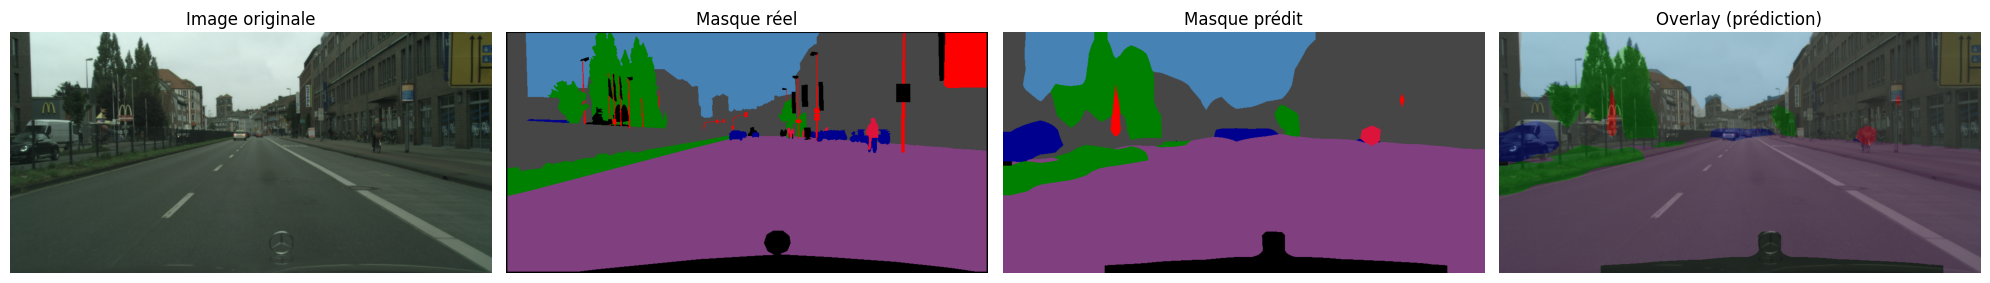

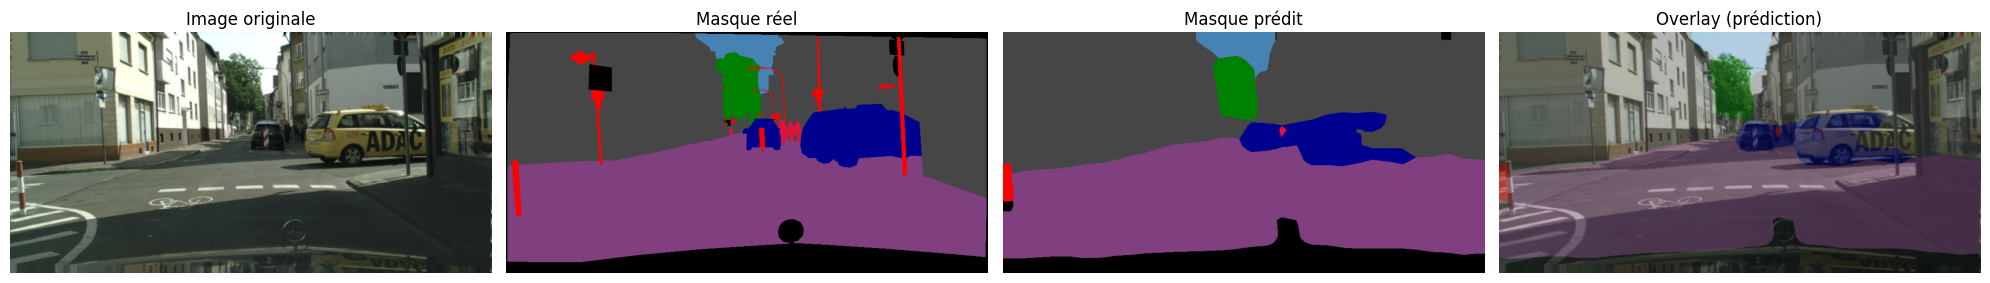

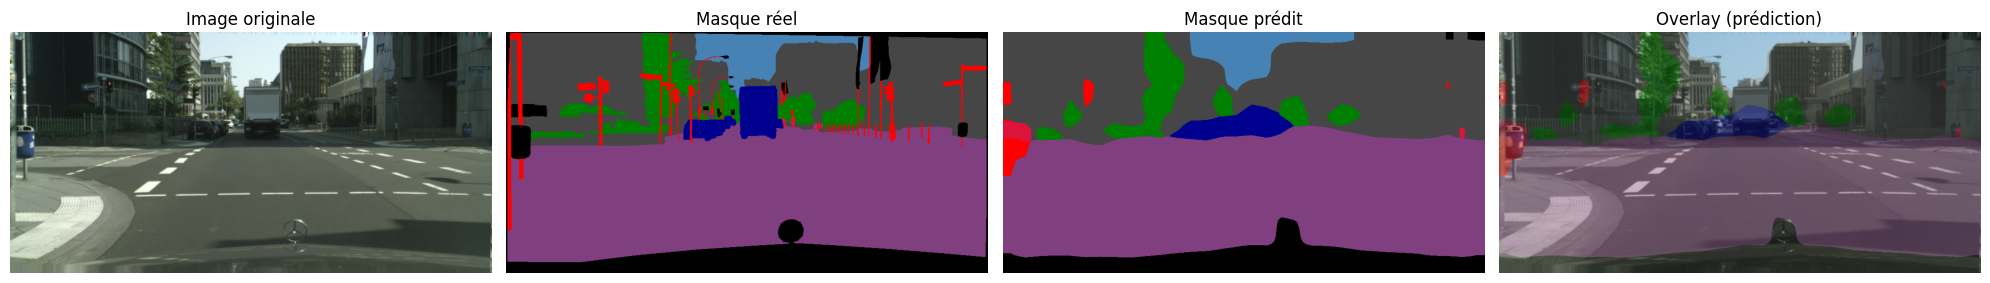

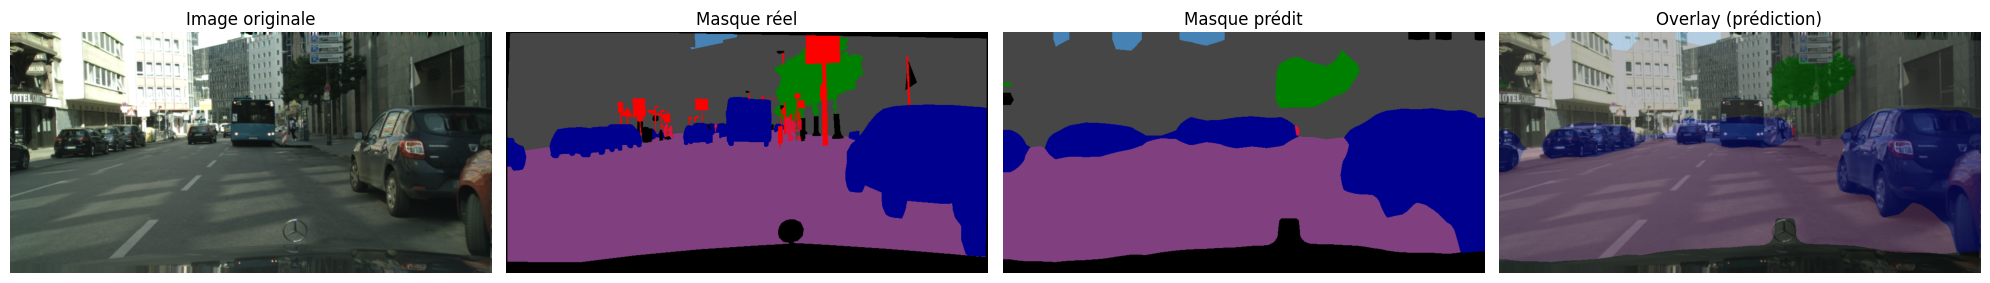

In [39]:
def decode_segmentation_mask(mask_2d):
    """
    Convertit un masque 2D (avec classes 0..7) en image RGB colorée pour visualisation.
    """
    colors = {
        0: (0, 0, 0),         # void - noir
        1: (128, 64, 128),    # flat - violet
        2: (70, 70, 70),      # construction - gris
        3: (255, 0, 0),       # object - rouge
        4: (0, 128, 0),       # nature - vert
        5: (70, 130, 180),    # sky - bleu ciel
        6: (220, 20, 60),     # human - rose
        7: (0, 0, 142),       # vehicle - bleu foncé
    }

    h, w = mask_2d.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in colors.items():
        rgb_mask[mask_2d == class_id] = color
    return rgb_mask


# Reconstruction du meilleur modèle SegFormer avec data augmentation via MLflow, avec les mêmes paramètres

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "/content/drive/MyDrive/Colab_Notebooks/P9/save/SegFormer_augmentationTrue_lr0.0005_wd0.01_batch_size8.pt"
model = SegFormer(num_classes=8)
# Charger les poids entraînés
model.load_state_dict(torch.load(best_model_path, map_location="cpu"))
model.to(device)
model.eval()

# Charger les images dans un dataset avec les mêmes prétraitements
dataset = MyCityscapesDataset(
    image_paths = ["/content/temp/Data/leftImg8bit/val/munster/munster_000004_000019_leftImg8bit.png",
                  "/content/temp/Data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png",
                  "/content/temp/Data/leftImg8bit/val/frankfurt/frankfurt_000000_011007_leftImg8bit.png",
                  "/content/temp/Data/leftImg8bit/val/frankfurt/frankfurt_000000_013382_leftImg8bit.png"],
    mask_paths = ["/content/temp/Data/gtFine/val/munster/munster_000004_000019_gtFine_labelIds.png",
                 "/content/temp/Data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png",
                 "/content/temp/Data/gtFine/val/frankfurt/frankfurt_000000_011007_gtFine_labelIds.png",
                 "/content/temp/Data/gtFine/val/frankfurt/frankfurt_000000_013382_gtFine_labelIds.png"],
    use_augmentations = False
    )
for i in range(4):
    img_tensor, mask_tensor = dataset[i]  # Tenseur image + masque (après preprocessing)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = ((img_np * 0.5) + 0.5) * 255
    img_np = np.clip(img_np, 0, 255).astype(np.uint8)
    true_mask = mask_tensor.numpy()

    # Prédiction
    with torch.no_grad():
        inputs = img_tensor.unsqueeze(0).to(device)
        preds, attentions, hidden_states = model(inputs, output_attentions=True, output_hidden_states=True)
        pred_mask = torch.argmax(preds, dim=1).squeeze(0).cpu().numpy()

    # Masques colorés
    pred_rgb = decode_segmentation_mask(pred_mask)
    true_rgb = decode_segmentation_mask(true_mask)

    # Superpositions
    overlay_pred = cv2.addWeighted(img_np, 0.6, pred_rgb, 0.4, 0)
    overlay_true = cv2.addWeighted(img_np, 0.6, true_rgb, 0.4, 0)

    # Affichage
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img_np)
    axes[0].set_title("Image originale")

    axes[1].imshow(true_rgb)
    axes[1].set_title("Masque réel")

    axes[2].imshow(pred_rgb)
    axes[2].set_title("Masque prédit")

    axes[3].imshow(overlay_pred)
    axes[3].set_title("Overlay (prédiction)")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

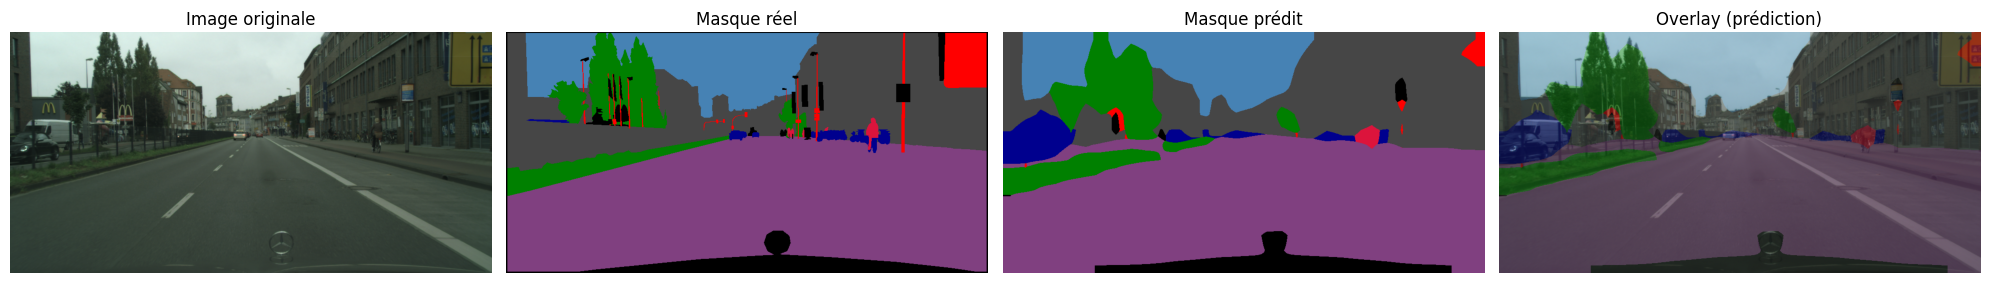

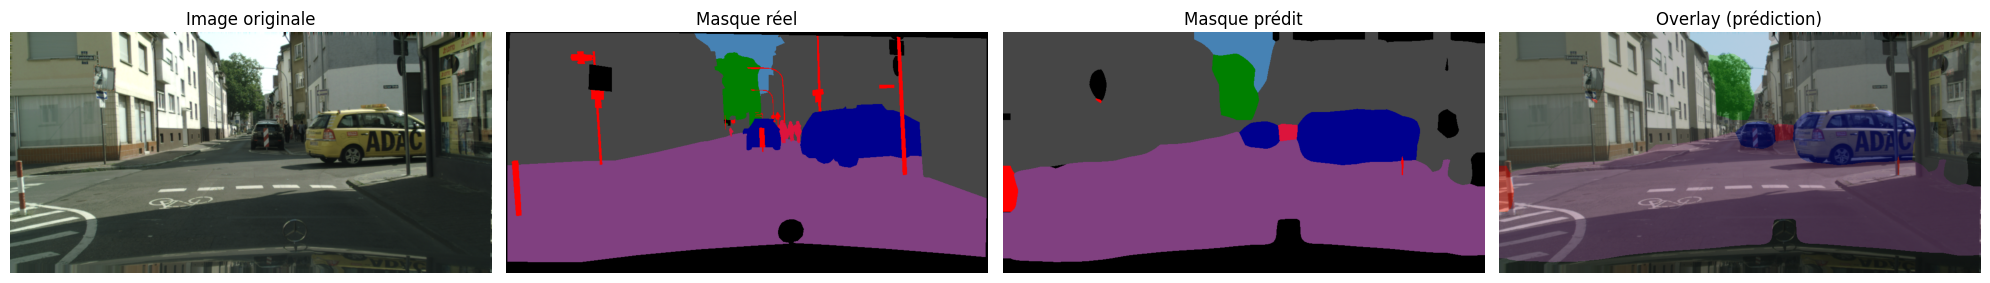

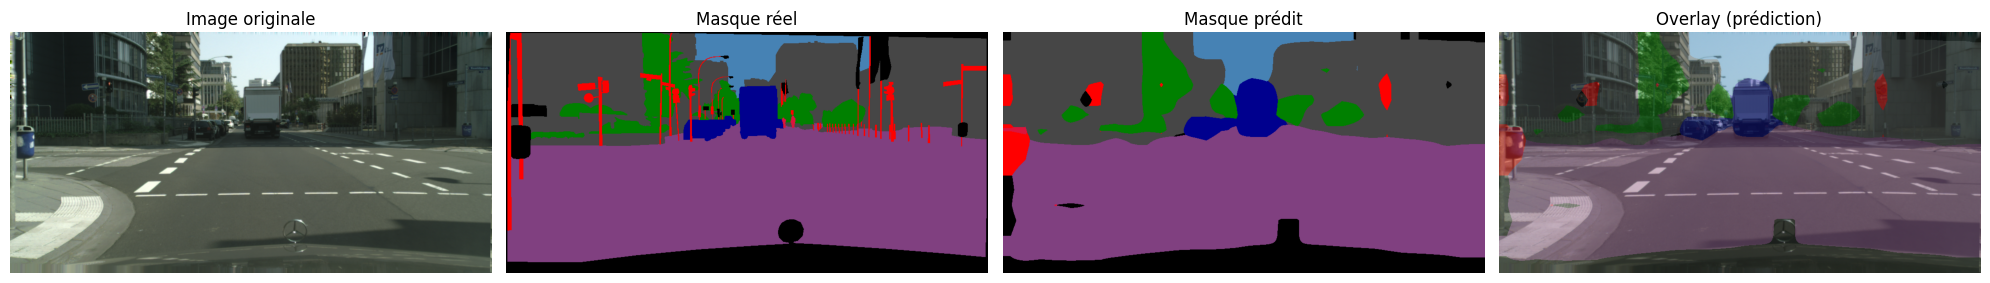

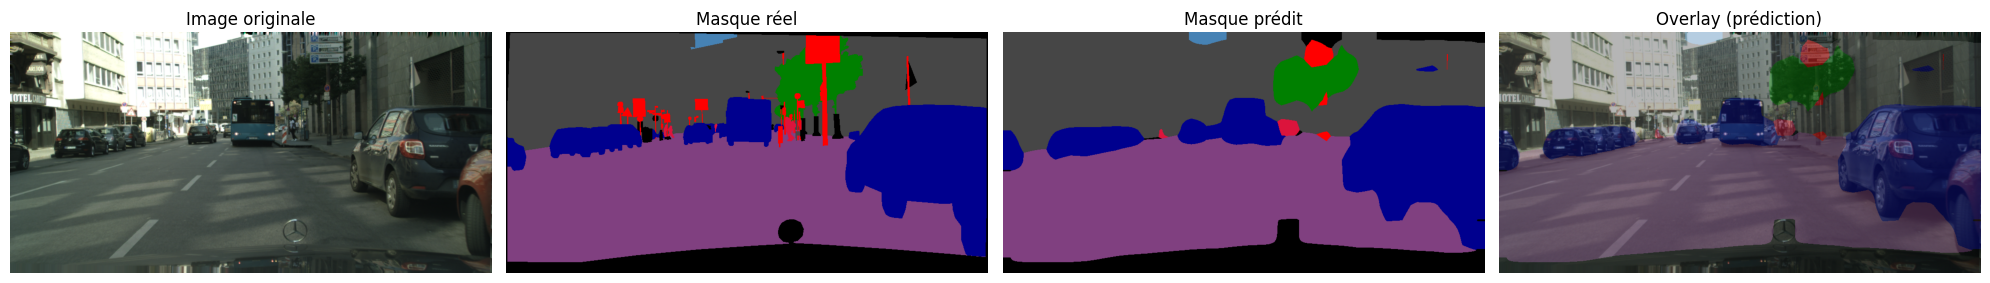

In [40]:
def decode_segmentation_mask(mask_2d):
    """
    Convertit un masque 2D (avec classes 0..7) en image RGB colorée pour visualisation.
    """
    colors = {
        0: (0, 0, 0),         # void - noir
        1: (128, 64, 128),    # flat - violet
        2: (70, 70, 70),      # construction - gris
        3: (255, 0, 0),       # object - rouge
        4: (0, 128, 0),       # nature - vert
        5: (70, 130, 180),    # sky - bleu ciel
        6: (220, 20, 60),     # human - rose
        7: (0, 0, 142),       # vehicle - bleu foncé
    }

    h, w = mask_2d.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in colors.items():
        rgb_mask[mask_2d == class_id] = color
    return rgb_mask


# Reconstruction du meilleur modèle SegFormer avec data augmentation via MLflow, avec les mêmes paramètres, après entrainement complet sur 50 epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model_path = "/content/drive/MyDrive/Colab_Notebooks/P9/save/SegFormer_epoch50_augmentationTrue_lr0.0005_wd0.01_batch_size8.pt"
model = SegFormer(num_classes=8)
# Charger les poids entraînés
model.load_state_dict(torch.load(best_model_path, map_location="cpu"))
model.to(device)
model.eval()

# Charger les images dans un dataset avec les mêmes prétraitements
dataset = MyCityscapesDataset(
    image_paths = ["/content/temp/Data/leftImg8bit/val/munster/munster_000004_000019_leftImg8bit.png",
                  "/content/temp/Data/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png",
                  "/content/temp/Data/leftImg8bit/val/frankfurt/frankfurt_000000_011007_leftImg8bit.png",
                  "/content/temp/Data/leftImg8bit/val/frankfurt/frankfurt_000000_013382_leftImg8bit.png"],
    mask_paths = ["/content/temp/Data/gtFine/val/munster/munster_000004_000019_gtFine_labelIds.png",
                 "/content/temp/Data/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_labelIds.png",
                 "/content/temp/Data/gtFine/val/frankfurt/frankfurt_000000_011007_gtFine_labelIds.png",
                 "/content/temp/Data/gtFine/val/frankfurt/frankfurt_000000_013382_gtFine_labelIds.png"],
    use_augmentations = False
    )
all_attentions =[]

for i in range(4):
    img_tensor, mask_tensor = dataset[i]  # Tenseur image + masque (après preprocessing)
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = ((img_np * 0.5) + 0.5) * 255
    img_np = np.clip(img_np, 0, 255).astype(np.uint8)
    true_mask = mask_tensor.numpy()

    # Prédiction
    with torch.no_grad():
        inputs = img_tensor.unsqueeze(0).to(device)
        preds, attentions, hidden_states = model(inputs, output_attentions=True, output_hidden_states=True)
        pred_mask = torch.argmax(preds, dim=1).squeeze(0).cpu().numpy()

    # Cartes d'attentions
    all_attentions.append(attentions)

    # Masques colorés
    pred_rgb = decode_segmentation_mask(pred_mask)
    true_rgb = decode_segmentation_mask(true_mask)

    # Superpositions
    overlay_pred = cv2.addWeighted(img_np, 0.6, pred_rgb, 0.4, 0)
    overlay_true = cv2.addWeighted(img_np, 0.6, true_rgb, 0.4, 0)

    # Affichage
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img_np)
    axes[0].set_title("Image originale")

    axes[1].imshow(true_rgb)
    axes[1].set_title("Masque réel")

    axes[2].imshow(pred_rgb)
    axes[2].set_title("Masque prédit")

    axes[3].imshow(overlay_pred)
    axes[3].set_title("Overlay (prédiction)")

    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

#### Importance globale

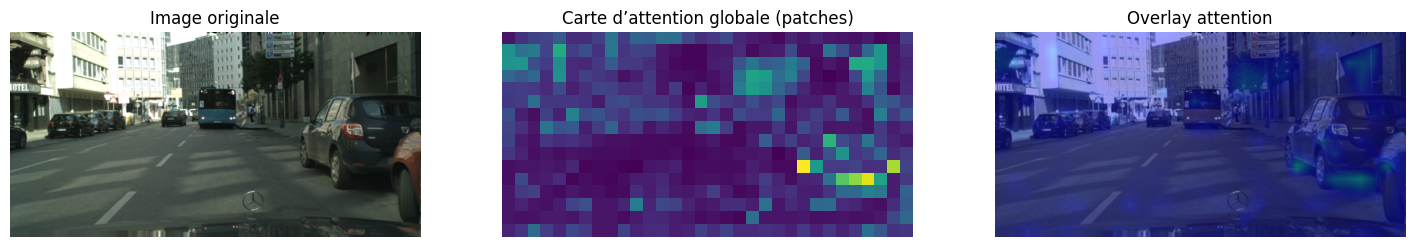

In [44]:
def compute_global_attention_overlay(img_np, all_attentions, hidden_states):
    att_maps = []

    # Parcours des couches d'attention avec leur feature map associée
    for i, att in enumerate(all_attentions):
        if isinstance(att, (tuple, list)):
            for sub in att:  # [B, heads, Nq, Nk]
                att_mean = sub.mean(1)          # [B, Nq, Nk]
                att_mean = att_mean[0].mean(0)  # [Nk]

                # Récupérer la taille spatiale réelle de la couche correspondante
                _, _, Hp, Wp = hidden_states[i].shape
                if Hp * Wp != att_mean.shape[0]:
                    continue  # skip si incohérent

                att_map = att_mean.reshape(Hp, Wp).cpu().numpy()
                att_map = (att_map - att_map.min()) / (att_map.max() - att_map.min() + 1e-8)
                att_maps.append(att_map)

    if not att_maps:
        raise ValueError("Aucune carte d'attention valide n'a été générée")

    # Moyenne des cartes valides
    att_global = np.mean(att_maps, axis=0)

    # Redimensionner à la taille de l'image
    att_resized = cv2.resize(att_global, (img_np.shape[1], img_np.shape[0]))
    att_resized = (att_resized * 255).astype(np.uint8)

    heatmap = cv2.applyColorMap(att_resized, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    return att_global, heatmap, overlay

# Exemple d’utilisationAC
att_map, heatmap, overlay = compute_global_attention_overlay(img_np, all_attentions, hidden_states)

# Affichage
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img_np)
axes[0].set_title("Image originale")
axes[0].axis("off")

axes[1].imshow(att_map, cmap="viridis")
axes[1].set_title("Carte d’attention globale (patches)")
axes[1].axis("off")

axes[2].imshow(overlay[..., ::-1])  # cv2 est en BGR
axes[2].set_title("Overlay attention")
axes[2].axis("off")

plt.show()

Sur la carte d'attention, plus la couleurs est claire (jaune/vert), plus le modèle a jugé ce patch informatif pour la prédiction.

On voit que des zones spécifiques, comme les voitures garées à droite, apparaissent en jaune/vert ce qui signifie que le modèle considère ces objets comme fortement discriminants pour la segmentation. Les zones uniformes, comme la route, restent bleues/violettes : l'attention est plus faible, car elles apportent peu d’information nouvelle puisque ce sont des régions larges et homogènes.

Globalement, cela montre que SegFormer exploite les objets structurés, comme les voitures, comme points de repère principaux. En revanche, les zones de contexte, comme la route, sont secondaires mais nécessaires pour la cohérence générale (activation faible).

Attention : la limite de l'importance globale est que la moyenne sur toutes les couches et têtes "lisse" beaucoup l’information, on perd souvent la spécialisation de certaines têtes qui pourraient regarder des détails (contours, textures). Pour corriger cela, regardons l'attention locale.

#### Importance locale

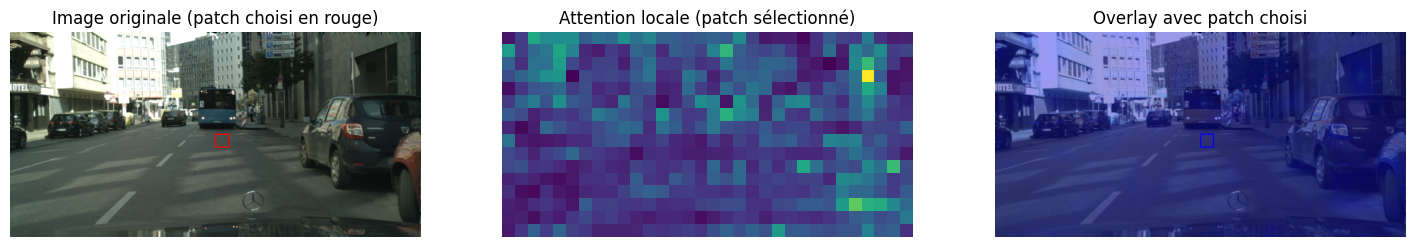

In [46]:
def compute_local_attention_overlay(img_np, all_attentions, patch_coords=None):
    """
    Analyse locale : visualise la carte d’attention d’un patch particulier
    et surligne ce patch sur les sorties.
    """
    att_maps = []
    Hp = Wp = None
    patch_idx = None

    for att in all_attentions:
        if isinstance(att, (tuple, list)):
            for sub in att:
                # sub : [B, heads, Nq, Nk]
                att_mean = sub.mean(1)[0]  # [Nq, Nk]

                Nq, Nk = att_mean.shape
                # Trouver automatiquement Hp, Wp
                candidates = [(h, Nk // h) for h in range(1, int(np.sqrt(Nk)) + 1) if Nk % h == 0]
                ratio_img = img_np.shape[0] / img_np.shape[1]
                Hp, Wp = min(candidates, key=lambda x: abs((x[0] / x[1]) - ratio_img))

                # Sélection du patch
                if patch_coords is None:
                    i, j = Hp // 2, Wp // 2
                else:
                    i, j = patch_coords
                patch_idx = i * Wp + j

                att_patch = att_mean[patch_idx]
                att_map = att_patch.reshape(Hp, Wp).cpu().numpy()
                att_map = (att_map - att_map.min()) / (att_map.max() - att_map.min() + 1e-8)
                att_maps.append(att_map)

    att_local = np.mean(att_maps, axis=0)

    # Resize à la taille image
    att_resized = cv2.resize(att_local, (img_np.shape[1], img_np.shape[0]))
    att_resized = (att_resized * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(att_resized, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

    # --- Mise en avant du patch sélectionné ---
    img_marked = img_np.copy().astype(np.uint8)
    if Hp is not None and Wp is not None and patch_idx is not None:
        # coordonnées du patch choisi
        i, j = divmod(patch_idx, Wp)
        h_patch = img_np.shape[0] // Hp
        w_patch = img_np.shape[1] // Wp
        y1, y2 = i * h_patch, (i + 1) * h_patch
        x1, x2 = j * w_patch, (j + 1) * w_patch

        # rectangle rouge sur image et overlay
        cv2.rectangle(img_marked, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.rectangle(overlay, (x1, y1), (x2, y2), (255, 0, 0), 2)

    return att_local, heatmap, overlay, img_marked

# Exemple d’utilisation : patch central
att_local, heatmap, overlay, img_marked = compute_local_attention_overlay(img_np, all_attentions)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img_marked)
axes[0].set_title("Image originale (patch choisi en rouge)")
axes[0].axis("off")

axes[1].imshow(att_local, cmap="viridis")
axes[1].set_title("Attention locale (patch sélectionné)")
axes[1].axis("off")

axes[2].imshow(overlay[..., ::-1])
axes[2].set_title("Overlay avec patch choisi")

axes[2].axis("off")

plt.show()

Le patch analysé au centre de la chaussée correspond à une petite zone asphaltée, sans objets particuliers.

Le fait que ce patch neutre de la chaussée « regarde » fortement vers des zones situées sur la droite de l’image (voitures en stationnement) et vers la zone proche du bus suggère que le modèle relie ce patch à des éléments de structure de la scène (limite de la chaussée, objets proches influents).

Cela montre que même une zone homogène (route) est interprétée en fonction de son contexte global : le modèle n’isole pas la route mais l’associe à ses frontières et aux objets mobiles.


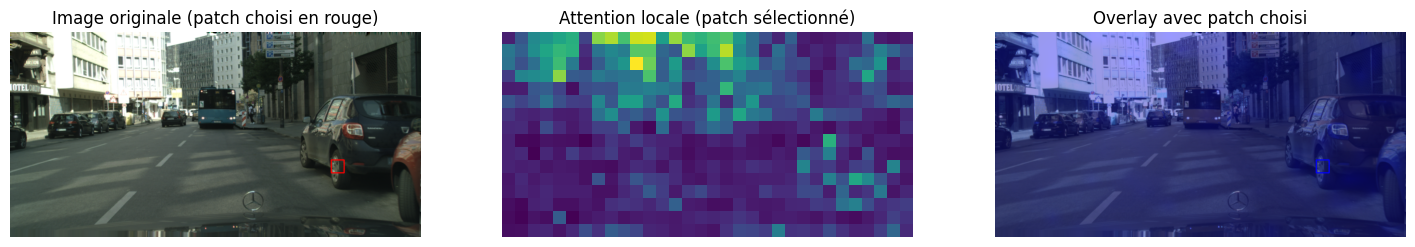

In [64]:
# Exemple d’utilisation : patch central
att_local, heatmap, overlay, img_marked = compute_local_attention_overlay(img_np, all_attentions,patch_coords=(10,25))

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img_marked)
axes[0].set_title("Image originale (patch choisi en rouge)")
axes[0].axis("off")

axes[1].imshow(att_local, cmap="viridis")
axes[1].set_title("Attention locale (patch sélectionné)")
axes[1].axis("off")

axes[2].imshow(overlay[..., ::-1])
axes[2].set_title("Overlay avec patch choisi")

axes[2].axis("off")

plt.show()

Le patch analysé ici couvre une zone d’un objet structurel fort (voiture).

On observe une forte activation vers le haut de l’image (zones claires en jaune/vert). Cela montre que ce patch n’est pas traité isolément mais qu’il se « connecte » à d’autres zones significatives :

Ici, le modèle associe le patch de la voiture non seulement à l’objet, mais aussi à l’arrière-plan (immeubles) qui co-occupe souvent la scène avec des véhicules stationnés.

In [12]:
ngrok.kill()
# https://dashboard.ngrok.com/agents    pour kill les sessions ngrok en cours

# Authentifier avec ton token
ngrok.set_auth_token("2waHSDEITs7Xn3gcB3stogIL4Ho_795MuQhFYDULrxjMPzNBJ")

mlflow_process = subprocess.Popen(
    ["mlflow", "ui", "--port", "5000" , "--backend-store-uri", "file:///content/drive/MyDrive/Colab_Notebooks/P9/mlruns"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

def print_stdout(proc):
    for line in proc.stdout:
        print("[MLFLOW STDOUT]", line.decode(), end="")

def print_stderr(proc):
    for line in proc.stderr:
        print("[MLFLOW STDERR]", line.decode(), end="")

threading.Thread(target=print_stdout, args=(mlflow_process,), daemon=True).start()
threading.Thread(target=print_stderr, args=(mlflow_process,), daemon=True).start()


# Tunnel avec ngrok vers ce port
time.sleep(5)  # Laisse le temps à mlflow de se lancer
public_url = ngrok.connect(5000)
print(f"MLflow UI est accessible ici : {public_url}")

MLflow UI est accessible ici : NgrokTunnel: "https://77fe390d0f6d.ngrok-free.app" -> "http://localhost:5000"


D'après les résultats visualisés sur MLflow, c'est le modèle SegFormer avec les paramètres suivants :

- avec data augmentation
- batch size de 8
- taux d'apprentissage de 0,0005
- dégradation des pondérations (weight decay) de 0,01.

qui obtient le meilleur mean_iou_weighted, notre métrique prioritaire.

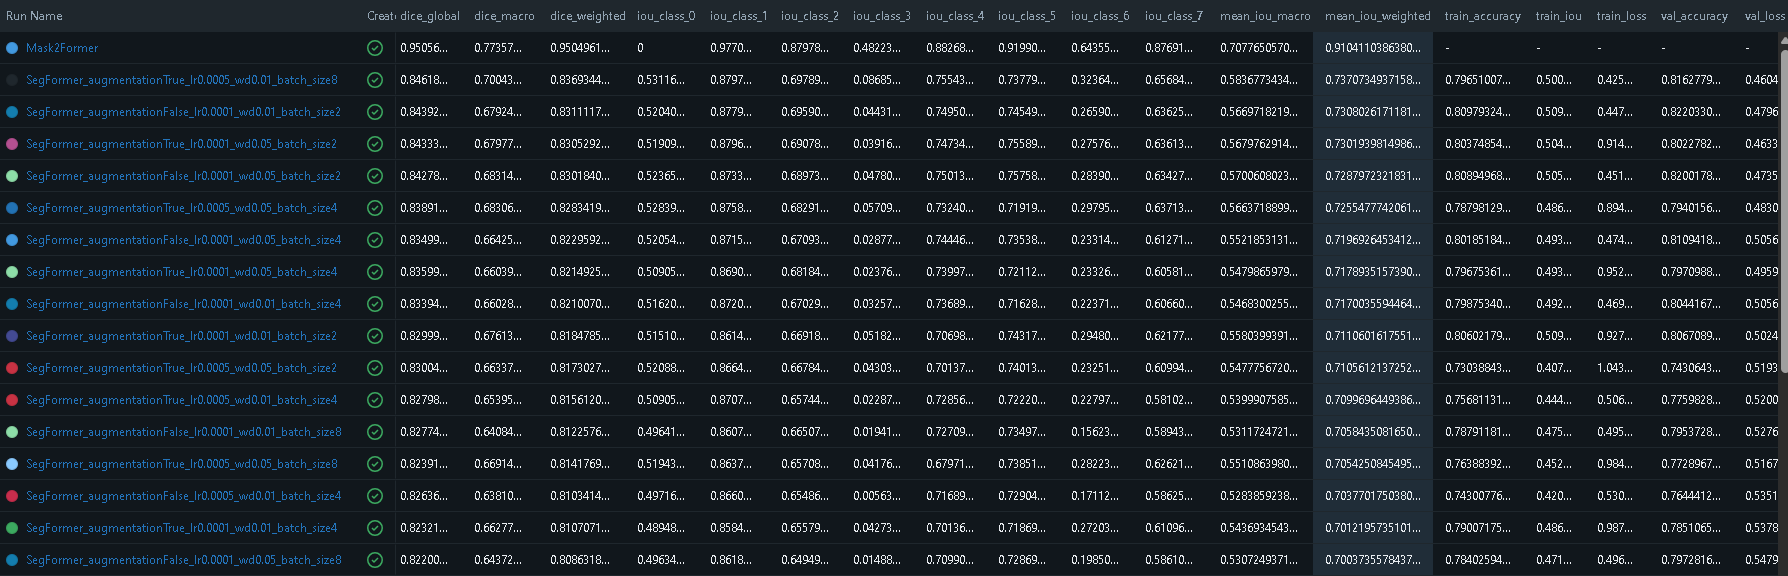

Un entrainement complet, c'est à dire sur 50 epochs, sera effectué pour pouvoir effectuer la comparaison avec le modèle U-net du projet 8.

Les résultats après l'entrainement complet sont :
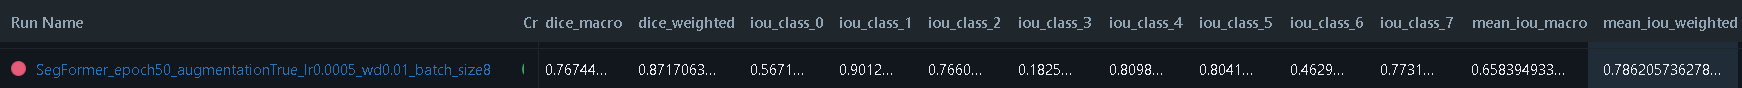

Comparés à ceux du modèle U-net entrainé sur 50 epochs du projet 8, les résultats de SegFormer entrainés sur 50 epochs sont moins bons.

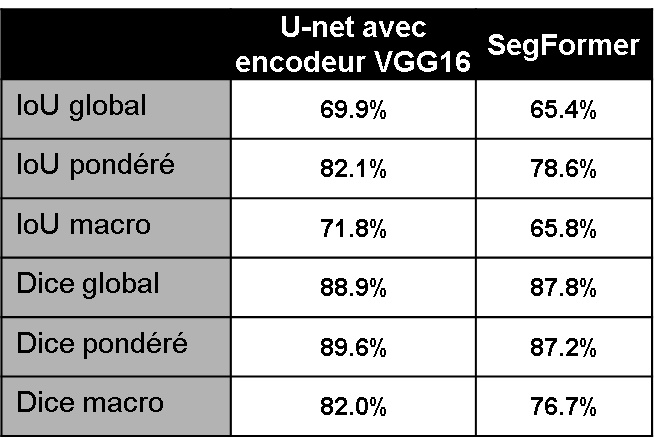

Ces résultats s'expliquent car mon modèle U-Net utilise un encodeur pré-entrainé contrairement à SegFormer qui est entrainé depuis le niveau zéro.

Si on prend le meilleur modèle U-Net from scratch et qu'on le compare à notre modèle SegFormer from scratch (seulement sur 5 epochs), le modèle SegFormer obtient de meilleurs résultats avec:

- IoU pondéré : 69.7% vs 73.7%
- IoU macro : 54.9% vs 58.4%
